In [1]:
%pip install pandas
%pip install scipy
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
import matplotlib.cm as cm
from read_arrays_from_csv import bhl_object_list, bhl_object_labels
from plot_variables import *
import yt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [134]:
def field_from_sliceplot(field, ds, disk, center, north, width_pc, dir, npixels=2048, radius=False):
    """
    Compute field from a slice plot of a dataset.
    Surface Density = slice plot density * cell height
    """
    p = yt.SlicePlot(ds, dir, ("gas", field), center=disk.center, width=(width_pc, "pc"), data_source=disk, north_vector=disk.normal_vector)
    slc_frb = p.data_source.to_frb((width_pc, "pc"), npixels)
    slc_field = slc_frb[("gas", field)]
    if radius:
        radius = slc_frb['radius'].to('pc')
        return slc_field, radius
    else:
        return slc_field
    
def ss_properties(ds, velocity=False):
    print("ds = ", ds)
    ad = ds.all_data()
    try:
        # find ss properties
        ss_creation = ad['SmartStar', 'creation_time'].to('yr')
        ss_pos = ad['SmartStar', 'particle_position'].to('unitary')[0]
        ss_mass = ad['SmartStar', 'particle_mass'].to('Msun')[0]

        # find ss age
        time = ds.current_time.to('yr').d
        creation = ss_creation.d  # strip units off variables
        ss_age = time - creation
    except:
        ss_pos = None
        ss_mass=0*yt.units.msun
        ss_age = [0*yt.units.Myr]

    if velocity:
        # find ss velocity
        ss_vel = ad['SmartStar', 'particle_velocity'].to('km/s')[0]
        return ss_pos, ss_mass, ss_age, ss_vel

    return ss_pos, ss_mass, ss_age

def _make_disk_L(ds, center, width_pc, height_pc):
    width = width_pc*yt.units.pc
    height = height_pc*yt.units.pc
    sp = ds.sphere(center, width)
    L = sp.quantities.angular_momentum_vector()
    L /= np.sqrt((L ** 2).sum()) # normal vector is N = L/|L|
    disk = ds.disk(center, L, width, height)
    return disk, L

In [100]:
ds = yt.load("/Backup00/sgordon/pleiades/seed1-bh-only/270msun/replicating-beckmann/1B.m16-4dx/DD0226/DD0226")

yt : [INFO     ] 2023-12-15 11:48:10,331 Parameters: current_time              = 14.041792748193
yt : [INFO     ] 2023-12-15 11:48:10,333 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-12-15 11:48:10,334 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-12-15 11:48:10,336 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-12-15 11:48:10,337 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-12-15 11:48:10,338 Parameters: current_redshift          = 26.166413915506
yt : [INFO     ] 2023-12-15 11:48:10,339 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-12-15 11:48:10,340 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-12-15 11:48:10,341 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-12-15 11:48:10,341 Parameters: hubble_constant           = 0.71


In [101]:
ss_pos, ss_mass, ss_age, ss_vel = ss_properties(ds, velocity=True)
disc_r_pc = 0.1
disc_h_pc = 0.1
_, L = _make_disk_L(ds, ss_pos, disc_r_pc, disc_h_pc)

ds =  DD0226


Parsing Hierarchy : 100%|██████████| 3044/3044 [00:00<00:00, 11319.62it/s]
yt : [INFO     ] 2023-12-15 11:48:10,820 Gathering a field list (this may take a moment.)


In [102]:
ss_pos, ss_mass, ss_age, ss_vel = ss_properties(ds, velocity=True)
ss_vel

ds =  DD0226


unyt_array([-0.97457708, -0.5256856 , -0.7469516 ], 'km/s')

In [112]:
from yt.utilities.math_utils import ortho_find
field = 'velocity_cylindrical_radius'
disc_h_pc = disc_r_pc = 0.8
width = 0.2
dir = L
vecs = ortho_find(L)
dir = vecs[0]
north = vecs[1]
disk = ds.disk(ss_pos, dir, disc_r_pc, disc_h_pc)
disk.set_field_parameter("center", ss_pos)
disk.set_field_parameter("bulk_velocity", ss_vel)
vel_r_cyl = field_from_sliceplot(field, ds, disk, ss_pos, north, width, dir, npixels=800, radius=False)

yt : [INFO     ] 2023-12-15 11:59:18,286 xlim = -0.000004 0.000004
yt : [INFO     ] 2023-12-15 11:59:18,289 ylim = -0.000004 0.000004
yt : [INFO     ] 2023-12-15 11:59:18,291 Making a fixed resolution buffer of (('gas', 'velocity_cylindrical_radius')) 800 by 800


In [113]:
dir

array([ 0.9637383 , -0.20611502,  0.16948477])

In [114]:
print(disk.quantities.angular_momentum_vector())

KeyboardInterrupt: 

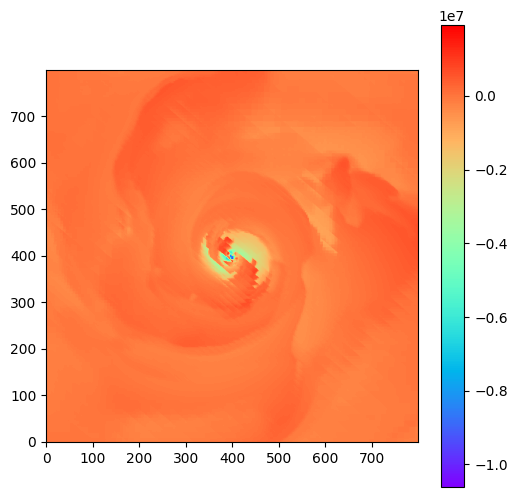

ss_age = [0.96010047] Myr, ss_mass = 2020.8916806405375 Msun, ds = DD0226


In [115]:
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(6,6))
im1 = plt.imshow(vel_r_cyl, cmap='rainbow', origin="lower")
#im1.set_clim(-20, 0)
plt.colorbar(im1)
plt.show()
print(f"ss_age = {ss_age/1e6} Myr, ss_mass = {ss_mass}, ds = {ds}")

yt : [INFO     ] 2023-12-15 12:04:18,429 xlim = -0.000004 0.000004
yt : [INFO     ] 2023-12-15 12:04:18,431 ylim = -0.000004 0.000004
yt : [INFO     ] 2023-12-15 12:04:18,433 Making a fixed resolution buffer of (('gas', 'velocity_cylindrical_radius')) 800 by 800



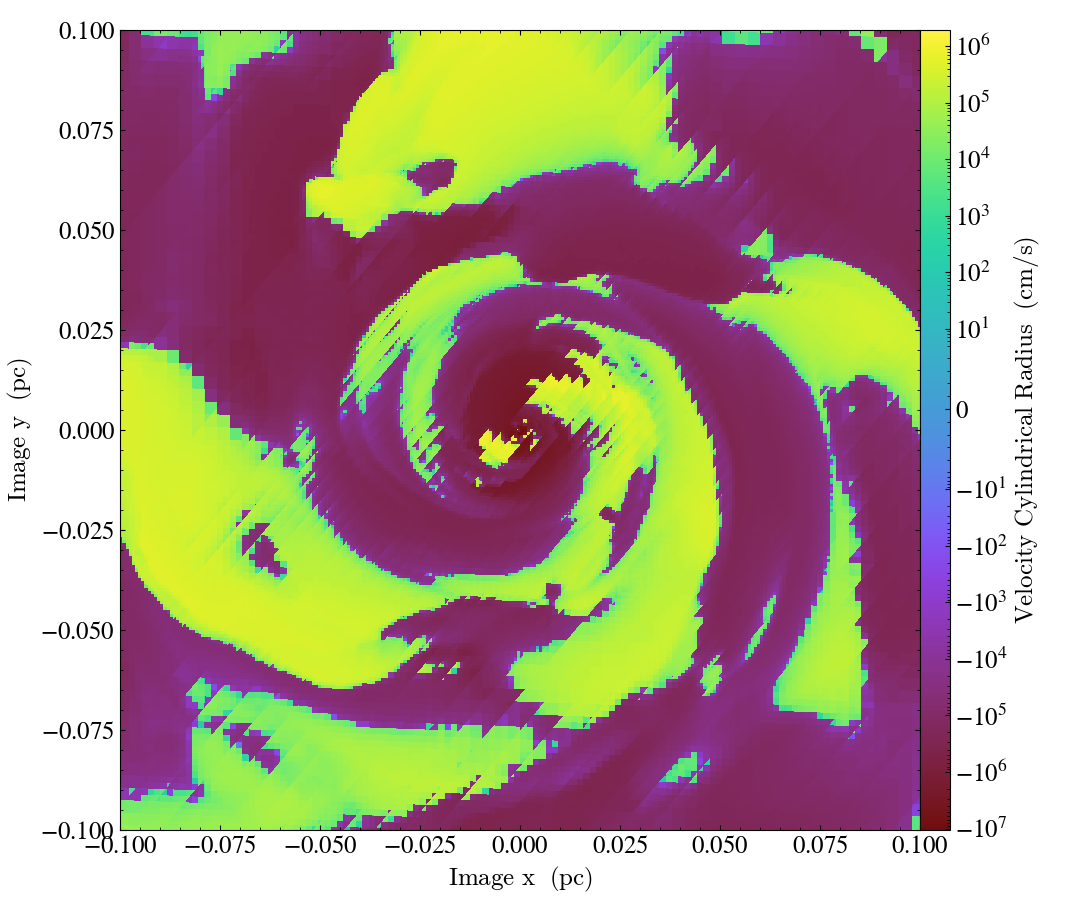

In [119]:
p = yt.SlicePlot(ds, dir, ("gas", "velocity_cylindrical_radius"), center=disk.center, width=(width, "pc"), data_source=disk, north_vector=north)
p.show()

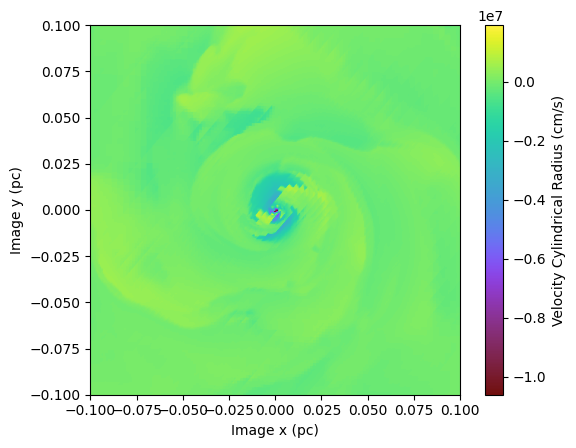

In [133]:
frb = p.data_source.to_frb((width, "pc"), 800, periodic=True)
vel_r_cyl = frb[("gas", "velocity_cylindrical_radius")]
bounds = (-width/2, width/2, -width/2, width/2)
plt.imshow(vel_r_cyl, cmap='arbre', extent=bounds, origin="lower", aspect='equal')

# Add a colorbar for reference
cbar = plt.colorbar()
cbar.set_label('Velocity Cylindrical Radius (cm/s)')

# Adjust colormap scaling to match yt's automatic scaling
vmin = vel_r_cyl.min()
vmax = vel_r_cyl.max()
plt.clim(vmin, vmax)

# Show the plot
plt.xlabel('Image x (pc)')
plt.ylabel('Image y (pc)')
plt.show()

In [57]:
print(f"ss_age = {ss_age/1e6} Myr, ss_mass = {ss_mass}, ds = {ds}")

ss_age = [0.96010047] Myr, ss_mass = 2020.8916806405375 Msun, ds = DD0226


In [58]:
def map_to_single_value(i, j, num_rows_per_set=6, num_columns=4):
    if 0 <= i < 12 and 0 <= j < 4:
        # Adjust 'i' for the second set of rows
        if i >= num_rows_per_set:
            i -= num_rows_per_set
            # Offset for the second half of the grid
            offset = num_columns * num_rows_per_set
        else:
            offset = 0

        # Column-major order mapping
        k = j * num_rows_per_set + i + offset
        print("i = {}, j = {}, k = {}".format(i, j, k))
        return k
    else:
        raise ValueError("i must be between 0 and 11, and j must be between 0 and 3")

In [3]:
map_to_single_value(2,2)

i = 2, j = 2, k = 14


14

In [6]:
def map_to_single_value(i, j, i_lim=11):
    if i < i_lim and (j == 0 or j == 1):
        k = i * 4 + j
        print("i < 6/3: i = {}, j = {}, k = {}".format(i, j, k))
    elif i >= i_lim and (j == 2 or j == 3):
        i -= i_lim
        k = i * 4 + j
        print("i >= 6/3: i = {}, j = {}, k = {}".format(i, j, k))
    else:
        raise ValueError("j must be between 0 and 3, and i must be between 0 and 11")
    return k


In [10]:
map_to_single_value(0,2)

ValueError: j must be between 0 and 3, and i must be between 0 and 11

In [15]:
def setup_plot_env(fontsize, linewidth):
    rc('font', **{'family': 'serif', 'serif': ['Times'], 'weight': 'light'})
    rc('text', usetex=True)
    plt.rcParams["mathtext.default"] = "regular"
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['lines.linewidth'] = linewidth


# Function to format and create the subplots
def create_subplots(num_subplots, xlim, ylim_mass, time_cutoff, fontsize, title):
    fig, axs = plt.subplots(num_subplots, 1, sharex=True)

    for i in range(num_subplots):
        axs[i].set_xticks(np.arange(0.1, time_cutoff+0.1, 0.1))
        axs[i].minorticks_on()
        axs[i].xaxis.set_minor_locator(plt.MultipleLocator(0.02))
        axs[i].tick_params(axis="x", which='minor', length=2, direction="in")
        axs[i].tick_params(axis="x", which='major', labelsize=fontsize-1, width=1.5, length=3, direction="in")
        axs[i].tick_params(axis="y", which='major', labelsize=fontsize-1)
        axs[i].tick_params(axis="y", which='minor', labelsize=fontsize-2)
        axs[i].set_yscale('log')
        axs[i].set_xlim([0, xlim+0.01]) # for truncated view

    axs[0].set_title(title)
    axs[0].set_ylim([10.5, ylim_mass+0.01]) # for truncated view 270msun: [240, ylim_mass+0.01]
    axs[0].set_ylabel(r"$\rm M_{BH} \, (M_{\odot})$", fontdict=None)
    axs[1].set_ylabel(r"$\rm \dot{M} \, (M_{\odot}/yr)$", fontdict=None)
    axs[1].set_ylim([2e-9, 8e-4]) # [2e-9, 8e-4] for 270msun, [5e-9, 6e-2] for 10.8msun-no-SN, [2e-9, 8e-4] for 10.8msun
    axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)

    return fig, axs

def plot_extra_line_mass_growth(j, data_file, label_extra, alpha=0.8):
        # Load the CSV file into a DataFrame
        df = pd.read_csv(data_file)

        # Extract the columns you're interested in
        age = df['age'].values/1e6
        bh_mass = df['BH mass'].values
        accrate = df['accrate'].values

        # 1) BH Mass
        axs[0].plot(age, bh_mass, color=c[j], linestyle='solid', label=label_extra, alpha=alpha)

        # 2) Accretion Rates
        axs[1].plot(age, accrate, color=c[j], linestyle='solid', label=label_extra, alpha=alpha)
        axs[1].plot(age, eddington_rate(bh_mass), color=c[j], linestyle='dashed', label=label_extra, alpha=alpha)

        return 0

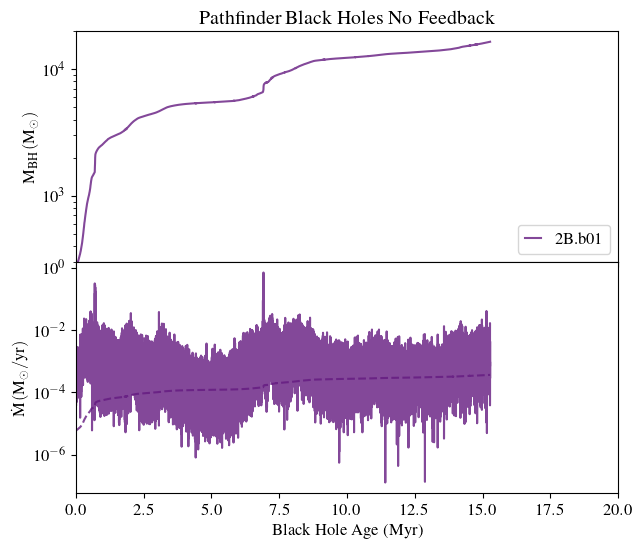

In [50]:
from plot_variables import moving_average

# Set axes limits 
time_cutoff = 20
ylim_mass = 2e4

# Set up plot environment
fontsize = 12
linewidth = 1.5
alpha = 0.8
setup_plot_env(fontsize, linewidth)
num_subplots = 2
title = 'Pathfinder Black Holes No Feedback'
fig, axs = plt.subplots(num_subplots, 1, sharex=True)

# Set limits and labels
axs[0].set_ylim([300, ylim_mass+0.01]) # for truncated view 270msun: [240, ylim_mass+0.01]
for i in range(num_subplots):
    axs[i].set_yscale('log')
    axs[i].set_xlim([0, time_cutoff]) # for truncated view
axs[0].set_ylabel(r"$\rm M_{BH} \, (M_{\odot})$", fontdict=None)
axs[1].set_ylabel(r"$\rm \dot{M} \, (M_{\odot}/yr)$", fontdict=None)
axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)

# Line colours
c_s1 = extract_colors('viridis', num_subplots-1, portion="middle", start=0.35, end=0.92) # start=0.33, end=0.92 for 10.8msun-no-sn
c_s2 = extract_colors('magma', num_subplots-1, portion="middle", start=0.3, end=0.85) # start=0.3, end=0.85 for 10.8msun-no-sn
c = np.concatenate((c_s1, c_s2))

# Load the CSV file into a DataFrame
data_files = [#'data_files/data-1B.RSb01-2.csv', 
              'data_files/data-2B.RSb01.csv']
labels = ['1B.b01', '2B.b01']
for j, data_file in enumerate(data_files):
    j +=1
    df = pd.read_csv(data_file)

    # Extract the columns you're interested in
    window_size = 1
    age = df['age'].values/1e6
    bh_mass = moving_average(df['BH mass'].values, window_size)
    accrate = moving_average(df['accrate'].values, window_size)
    #age = np.linspace(age[0], times[-1], len(accrate))

    # 1) BH Mass
    axs[0].plot(age, bh_mass, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

    # 2) Accretion Rates
    axs[1].plot(age, accrate, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    axs[1].plot(age, eddington_rate(bh_mass), color=c[j], linestyle='dashed', label=labels[j], alpha=alpha)


axs[0].legend(fontsize=fontsize, ncol=2, loc="lower right", handlelength=1) # "lower right" for no-sn
#axs[1].legend(accrate_line, [r"$\rm \dot{M}_{Edd}$"], loc="lower right", fontsize=fontsize-2.2, ncol=1)
fig.subplots_adjust(wspace=0, hspace=0)
axs[0].set_title(title)
fig.set_size_inches(7, 6)
plt.savefig(f'no-feedback-pathfinders/mass_accrate_{labels[0]}_{labels[1]}_{time_cutoff}.pdf', bbox_inches='tight')
plt.show()

In [ ]:
plt.savefig(f'no-feedback-pathfinders/mass_accrate_{labels[0]}_{labels[1]}_{time_cutoff}.pdf', bbox_inches='tight')